In [362]:
import numpy as np
import matplotlib.pyplot as plt
import math as m


In [435]:
resolution = 4
phi = np.random.rand()*2*np.pi
xAxis = np.arange(0, 1, 1/resolution)

#signal
signal = np.sin(2*np.pi*xAxis/gratingP + phi)+1
LoseContrast = signal + 2
signalP = np.random.poisson(LoseContrast)

#error bars for LoseContrast
errorBars = LoseContrast**0.5

#truthy signal
xT = np.linspace(0, gratingP, 1000)
signalT = np.sin(2*np.pi*xT/gratingP + phi)+3

print(xAxis)

[0.   0.25 0.5  0.75]


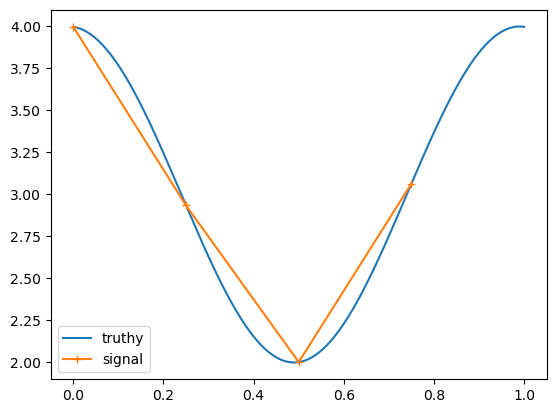

In [436]:
plt.plot(xT, signalT, label='truthy')
plt.plot(xAxis, LoseContrast,'+-',label='signal')
plt.legend()

In [383]:
#calculate the error with discrete sampling a sine wave n times
#this calculates what fraction of the full amplitude is recorded by the discrete sampling
tests = 100000
phi =  np.random.rand(tests)*2*np.pi
samples = 25
expectCon = np.zeros(samples)

#generated average maxMin difference
minMaxAvg = np.zeros(samples)
minMaxMin = np.zeros(samples)
sampleArr = np.arange(0, samples, 1)

for i in range(1, samples):
    #table for 1000 runs
    results = np.zeros(tests)
    for k in range(0, tests):
        sineArr = np.zeros(i)
        for j in range(0, i):
            sineArr[j] = np.sin(2*np.pi*j/i + phi[k])+3
        max = np.max(sineArr)
        min = np.min(sineArr)
        results[k] = max - min

    minMaxAvg[i] = np.mean(results)/2
    minMaxMin[i] = np.min(results)/2
            


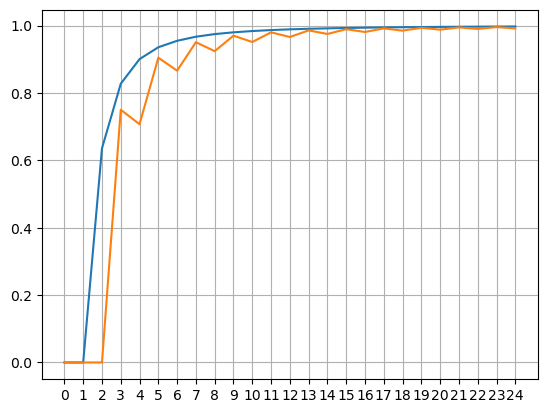

[0.         0.         0.63528745 0.82719004 0.90027849 0.93552374
 0.95467179 0.96677384 0.97453366 0.97980074 0.98358585 0.98645627
 0.98863691 0.99030148 0.99158461 0.99270535 0.9935979  0.99432359
 0.99494883 0.99544966 0.99589863 0.9962786  0.99660788 0.9968966
 0.9971453 ]
[0.00000000e+00 0.00000000e+00 1.29345002e-05 7.50000820e-01
 7.07114197e-01 9.04509054e-01 8.66026221e-01 9.50484845e-01
 9.23880867e-01 9.69846337e-01 9.51060513e-01 9.79746533e-01
 9.65926194e-01 9.85470925e-01 9.74928459e-01 9.89073997e-01
 9.80785505e-01 9.91486590e-01 9.84808037e-01 9.93180773e-01
 9.87688588e-01 9.94415554e-01 9.89821579e-01 9.95343013e-01
 9.91445032e-01]


In [382]:
plt.plot(sampleArr, minMaxAvg)
plt.plot(sampleArr, minMaxMin)
plt.xticks(np.arange(0,len(sampleArr),1))
plt.grid(True)
plt.show()
print(minMaxAvg)
print(minMaxMin)

In [384]:
###########
#Now we can figure out the time we need to wait for each sample then multiply by the number of samples

In [430]:
def N(rate, time):
    return rate*time

def contrast(max, min):
    return (max-min)/(max+min)

def maxMin(contrast):
    return (1+contrast)/(1-contrast)

#sigma to percentile
def sigmaP(sigma):
    return m.erf(sigma/np.sqrt(2))

def timeToWait(samples, rate, sigma, contrast):
    x = (1-sigmaP(sigma))*(maxMin(contrast)-1)*(minMaxAvg[samples])
    norm = samples/rate
    return norm/x**2

def expDecay(lengthmm, speedMS, timeconstantUs):
    length = lengthmm/1000
    time = length / speedMS
    timeconstantS = timeconstantUs*1e-6
    return np.exp(-time/timeconstantS)

def solidAngle(detectorSizeMM, distAwayCM):
    detArea = (detectorSizeMM/1000)**2
    distAway = distAwayCM/100
    return detArea/(4*np.pi*distAway**2) * 4 #times 2 for top bottom left right


In [431]:
samplePerSin = 7 
MuRate = 1000 #per second
solidRate = MuRate * solidAngle(5, 5)
#take into account expdecay before detectors
realRate = solidRate * expDecay(1.5, 2175, 2.2)
sigma = 3 #3 sigma threshold i.e. 95th percentile
contrast = 0.3
print(timeToWait(samplePerSin, realRate, sigma, contrast)/3600)

166.98500074718274


(1.8, 10.0)

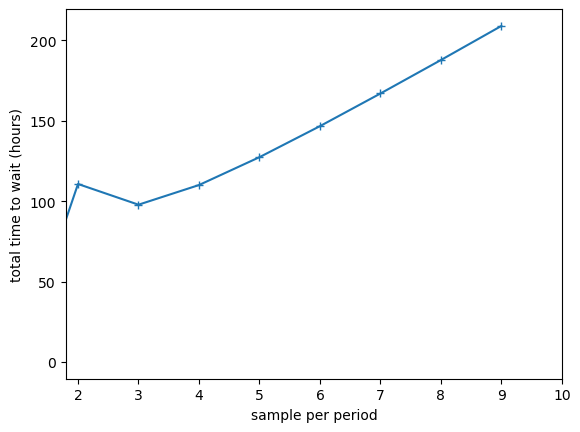

In [432]:
limit = 10
time = np.zeros(limit)
for samples in range(2,limit):
    time[samples] = timeToWait(samples, realRate, sigma, contrast)/3600

plt.plot(time, '+-')
plt.xlabel('sample per period')
plt.ylabel('total time to wait (hours)')
plt.xticks(np.arange(0, limit+1, 1))
plt.xlim(1.8, limit)